# Goal
This notebook contains script that loads the SNP embeddings and train an autoencoder.
Specifically, we only use sibling data, which gives 50% target split between wildtype and ASD.

In [49]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm
import scipy.sparse as sp

## Prepare the data

### Load the ID map and screen for p1 & s1

In [66]:
id_map = pd.read_csv("../../Data/SSC_VEP_GZ/documentation/nygc_sfari_id_map.csv")
id_map['Role'] = id_map['SFARI ID'].apply(lambda x: x.split(".")[1])
# Get the count of each unique value in the 'Role' column
role_counts = id_map['Role'].value_counts()

# Use f-string to report the count of each value
for role, count in role_counts.items():
    print(f"The number of occurrences for '{role}' is {count}")

id_map = id_map[id_map['Role'].isin(['p1', 'fa'])]

The number of occurrences for 'fa' is 2459
The number of occurrences for 'mo' is 2459
The number of occurrences for 'p1' is 2459
The number of occurrences for 's1' is 1994
The number of occurrences for 's2' is 14


### Load GRN embedding

In [67]:
# Directories for input and output
output_dir = '../../Data/SSC_VEP_filtered'
image_output_dir = '../../Image'
os.makedirs(image_output_dir, exist_ok=True)

# Folder where all CSV files are located
csv_folder = '../../Data/TF_Embeddings_Multiclass/'

# Load and concatenate all CSV files in the folder
csv_files = [os.path.join(csv_folder, file) for file in os.listdir(csv_folder) if file.endswith('.csv')]

# Initialize an empty list to hold DataFrames
dfs = []

# Loop through the list of files and load each CSV, then append to the list
for file in csv_files:
    df = pd.read_csv(file, index_col=0)
    dfs.append(df)

# Concatenate all DataFrames into one
embedding_matrix_raw = pd.concat(dfs)

# Ensure the data type is int for tensor conversion
embedding_matrix_raw = embedding_matrix_raw.astype(int)

# Modify the index to remove '.bed' from file names
embedding_matrix_raw.index = [x.replace('.bed', "") for x in embedding_matrix_raw.index]


### Merge the ID map with embedding

In [68]:
# Merge the DataFrames based on the 'Repository Id' column
embedding_matrix = pd.merge(id_map, embedding_matrix_raw, left_on='Repository Id', right_index=True)
embedding_matrix['ASD'] = embedding_matrix['Role'].apply(lambda x: 1 if x == 'p1' else 0)

### Remove useless columns
The `y` object is the target variable.
The `meta` object has the SFARI ID and Repository ID information of each observation.
The new `embedding_matrix` will only contain the input variable

In [69]:
print(f'Embedding matrix shape: {embedding_matrix.shape}')
print(f'Embedding matrix type: {type(embedding_matrix)}')

# Extract the target and meta columns
y = embedding_matrix['Role'].values
meta = embedding_matrix.loc[:, ['SFARI ID', 'Repository Id']]

# Filter for TF cols only
TF_Cols = [True if 'ENS' in col else False for col in embedding_matrix.columns]
embedding_matrix = embedding_matrix.loc[:, TF_Cols]
print(f'Embedding matrix shape after removing enhancer cols: {embedding_matrix.shape}')

# Remove all zero columns
embedding_matrix = embedding_matrix.loc[:,embedding_matrix.sum()>0]
print(f'Embedding matrix shape after removing all zero and enhancer cols: {embedding_matrix.shape}')

# Remove all one columns
embedding_matrix = embedding_matrix.loc[:, (embedding_matrix != 1).any(axis=0)]
print(f'Embedding matrix shape after removing all zero and all one and enhancer cols: {embedding_matrix.shape}')

# Remove all one columns
embedding_matrix = embedding_matrix.loc[:, (embedding_matrix != 2).any(axis=0)]
print(f'Embedding matrix shape after removing all zero all one and all two and enhancer cols: {embedding_matrix.shape}')

# Check for any issues in the embedding matrix
if np.any(np.isnan(embedding_matrix)):
    raise ValueError("Embedding matrix contains NaN values")

Embedding matrix shape: (1532, 50603)
Embedding matrix type: <class 'pandas.core.frame.DataFrame'>
Embedding matrix shape after removing enhancer cols: (1532, 8564)
Embedding matrix shape after removing all zero and enhancer cols: (1532, 5803)
Embedding matrix shape after removing all zero and all one and enhancer cols: (1532, 2622)
Embedding matrix shape after removing all zero all one and all two and enhancer cols: (1532, 2596)


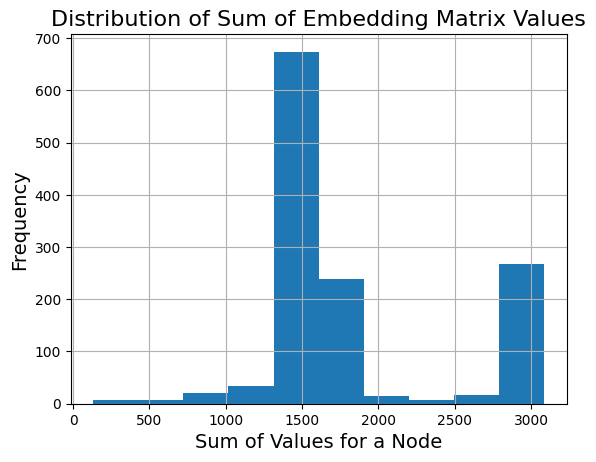

In [64]:
import matplotlib.pyplot as plt

# Plot the histogram of the sum of values in the embedding matrix
embedding_matrix.sum().hist()

# Add labels and a title
plt.title('Distribution of Sum of Embedding Matrix Values', fontsize=16)
plt.xlabel('Sum of Values for a Node', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Display the plot
plt.show()


## Train the autoencoder

### Define the model

In [56]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

class LargeDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        batch = self.data.iloc[idx]
        batch_tensor = torch.tensor(batch.values, dtype=torch.float32)
        return batch_tensor, batch_tensor  # Returning the same tensor as input and target


# Create a dataset and dataloader
dataset = LargeDataset(embedding_matrix)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Train the Autoencoder in Batches

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, code_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, code_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(code_dim, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, input_dim),
            nn.ReLU() 
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


In [58]:
# Set parameters
input_dim = embedding_matrix.shape[1]
hidden_dim1 = 256
hidden_dim2 = 256
code_dim = 128  # Adjusted reduced dimension

# Initialize autoencoder
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = Autoencoder(input_dim, hidden_dim1, hidden_dim2, code_dim).to(device)

# Training settings
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
num_epochs = 50
batch_size = 32

# Custom dataset and dataloader
class LargeDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        batch = self.data.iloc[idx]
        batch_tensor = torch.tensor(batch.values, dtype=torch.float32)
        return batch_tensor, batch_tensor  # Returning the same tensor as input and target

dataset = LargeDataset(embedding_matrix)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop with overall progress bar
progress_bar = tqdm(total=num_epochs, desc='Training Autoencoder', unit='epoch')

for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_features, _ in dataloader:
        batch_features = batch_features.to(device)

        optimizer.zero_grad()
        encoded, decoded = autoencoder(batch_features)
        loss = criterion(decoded, batch_features)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    progress_bar.set_postfix({'loss': epoch_loss / len(dataloader)})
    progress_bar.update(1)
progress_bar.close()

# Extract the encoded features and calculate reconstruction error
autoencoder.eval()
encoded_embeddings = []
reconstruction_errors = []

with torch.no_grad():
    for batch_features, _ in dataloader:
        batch_features = batch_features.to(device)
        encoded, decoded = autoencoder(batch_features)
        encoded_embeddings.append(encoded.cpu().numpy())
        
        # Calculate reconstruction error for the batch
        batch_mse = F.mse_loss(decoded, batch_features, reduction='none').mean(dim=1)
        reconstruction_errors.append(batch_mse.cpu().numpy())

encoded_embeddings = np.vstack(encoded_embeddings)
reconstruction_errors = np.concatenate(reconstruction_errors)

# Calculate overall reconstruction accuracy
average_reconstruction_error = reconstruction_errors.mean()
print(f'Average Reconstruction Error (MSE): {average_reconstruction_error}')

# Print the shape of the encoded embeddings
print(f'Encoded embeddings shape: {encoded_embeddings.shape}')


Training Autoencoder:   0%|          | 0/50 [00:00<?, ?epoch/s]

Average Reconstruction Error (MSE): 0.27599987387657166
Encoded embeddings shape: (1511, 128)


In [10]:
# Save the trained autoencoder model
autoencoder_path = 'autoencoder.pth'
torch.save(autoencoder.state_dict(), autoencoder_path)
print(f'Autoencoder model saved to {autoencoder_path}')


Autoencoder model saved to autoencoder.pth


In [11]:
import numpy as np

# Assuming encoded_embeddings is already computed
# Save the encoded embeddings to a file
encoded_embeddings_path = 'encoded_embeddings.npy'
np.save(encoded_embeddings_path, encoded_embeddings)
print(f'Encoded embeddings saved to {encoded_embeddings_path}')


Encoded embeddings saved to encoded_embeddings.npy


In [12]:
import pandas as pd

# Convert encoded embeddings to a DataFrame
encoded_embeddings_df = pd.DataFrame(encoded_embeddings, index=embedding_matrix.index)

# Save the DataFrame to a CSV file
encoded_embeddings_df.to_csv('encoded_embeddings.csv')
print('Encoded embeddings saved to encoded_embeddings.csv')


Encoded embeddings saved to encoded_embeddings.csv


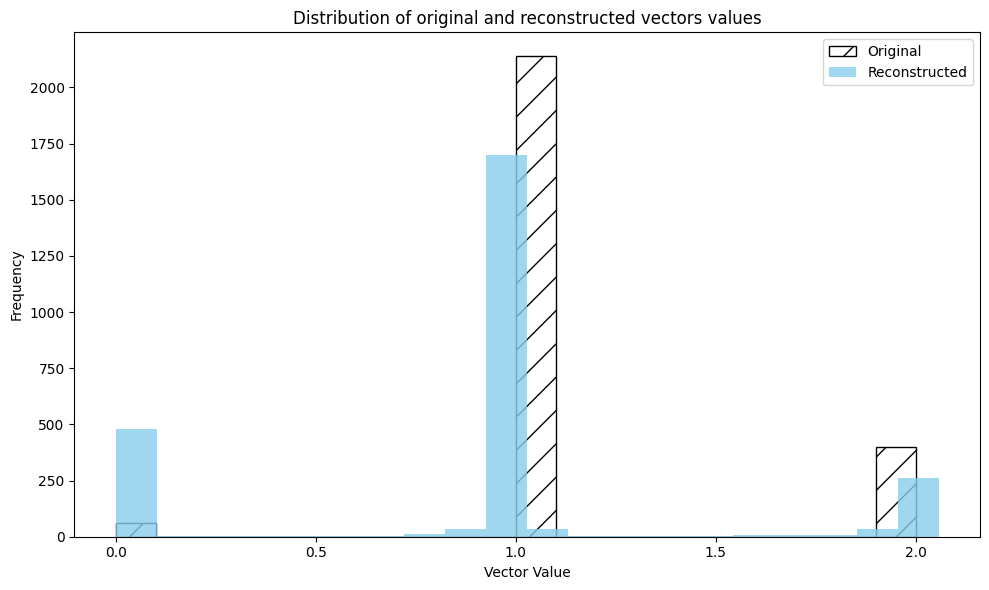

In [13]:
import matplotlib.pyplot as plt
i = 0

def plot_dist(i):
    foo = decoded[i].cpu()
    bar = batch_features[i].cpu()
    
    # Convert tensors to numpy arrays for plotting
    foo_np = foo.numpy()
    bar_np = bar.numpy()
    
    # Plot the histograms with different styles
    plt.figure(figsize=(10, 6))
    
    plt.hist(bar_np, bins=20, color='white', edgecolor='black', label='Original', hatch='/')
    plt.hist(foo_np, bins=20, color='skyblue', alpha=0.8, label='Reconstructed', hatch='')
    
    plt.title('Distribution of original and reconstructed vectors values')
    plt.xlabel('Vector Value')
    plt.ylabel('Frequency')
    #plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(image_output_dir, 'Distribution of values in the Input and output vectors.jpg'))
    plt.show()

plot_dist(i)


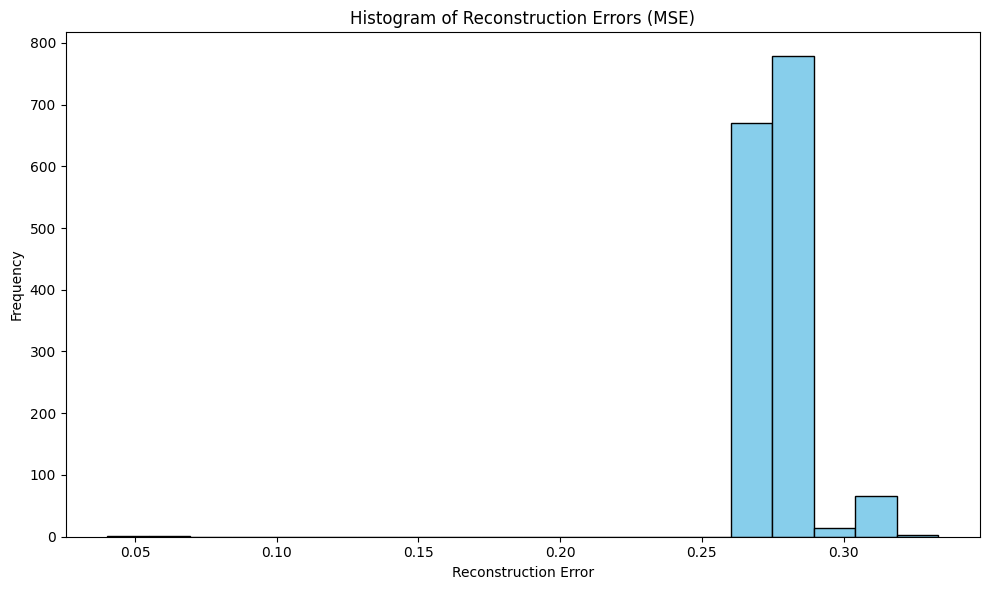

In [14]:
import matplotlib.pyplot as plt

# Plot the histogram of reconstruction errors
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Reconstruction Errors (MSE)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(os.path.join(image_output_dir, 'reconstruction_error_histogram.png'))
plt.show()

### Define X,y

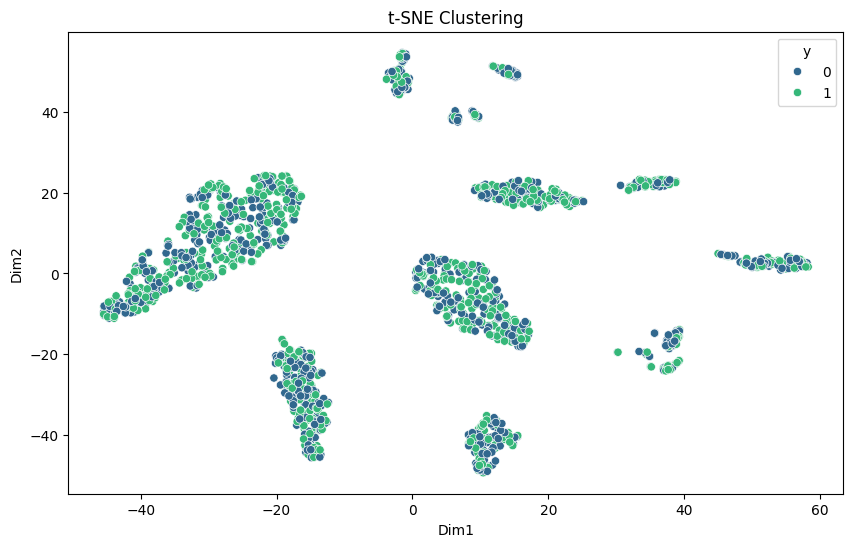

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd

# Assuming X is your encoded embedding dataframe and y is your labels
# Step 1: Apply t-SNE to reduce X to 2 dimensions for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Step 2: Convert the result to a DataFrame for easier plotting
df_tsne = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
df_tsne['y'] = y  # Add y (labels) to the DataFrame for color coding

# Step 3: Plot the t-SNE result and color-code by y
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Dim1', y='Dim2', hue='y', palette='viridis', data=df_tsne)
plt.title('t-SNE Clustering')
plt.show()


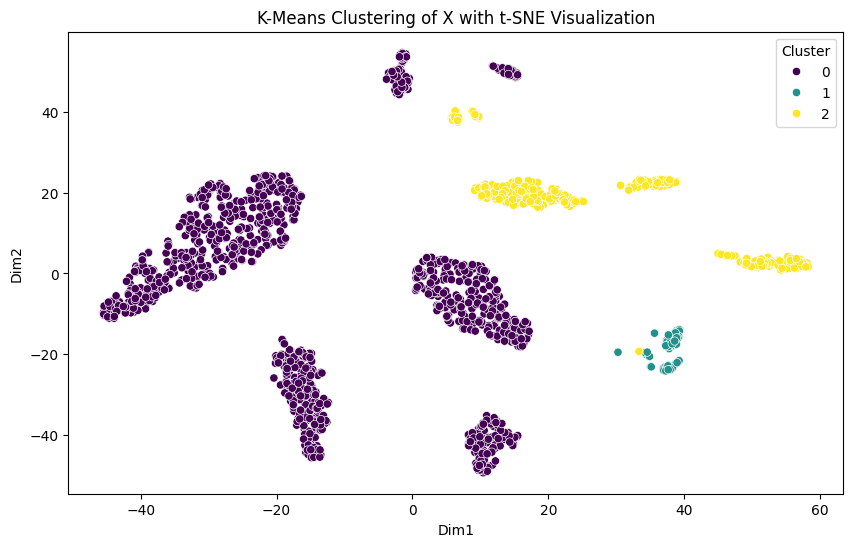

In [35]:
from sklearn.cluster import KMeans

# Step 1: Apply K-Means to cluster the data in X
kmeans = KMeans(n_clusters=3, random_state=42)  # Choose the number of clusters (n_clusters)
y_kmeans = kmeans.fit_predict(X)

# Step 2: Use the t-SNE results (or just X_tsne if you used t-SNE above)
df_tsne['Cluster'] = y_kmeans

# Step 3: Plot the clusters with t-SNE visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Dim1', y='Dim2', hue='Cluster', palette='viridis', data=df_tsne)
plt.title('K-Means Clustering of X with t-SNE Visualization')
plt.show()


In [36]:
pip install umap-learn

  Using cached umap_learn-0.5.6-py3-none-any.whl.metadata (21 kB)
Using cached umap_learn-0.5.6-py3-none-any.whl (85 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 6.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 26.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


/opt/anaconda3/envs/GRN/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


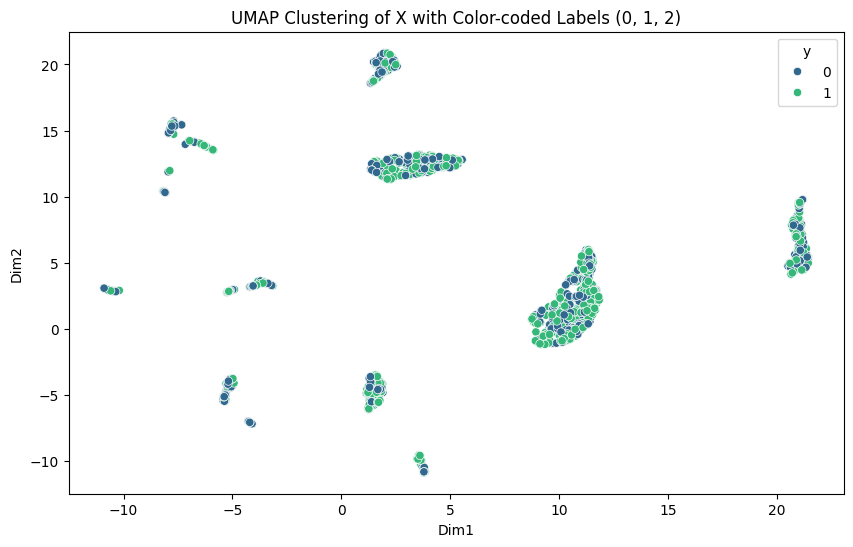

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd

# Assuming X is your encoded embedding dataframe and y contains the labels (0, 1, 2)
# Step 1: Apply UMAP to reduce X to 2 dimensions for visualization
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X)

# Step 2: Convert the result to a DataFrame for easier plotting
df_umap = pd.DataFrame(X_umap, columns=['Dim1', 'Dim2'])
df_umap['y'] = y  # Add y (labels 0, 1, 2) to the DataFrame for color coding

# Step 3: Plot the UMAP result and color-code by y
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Dim1', y='Dim2', hue='y', palette='viridis', data=df_umap)
plt.title('UMAP Clustering of X with Color-coded Labels (0, 1, 2)')
plt.show()


In [15]:
X = encoded_embeddings_df.values
y = np.where(y == 'p1', 1, 0)
print(f'Feature matrix shape: {X.shape}')
print(f'Labels shape: {y.shape}')

Feature matrix shape: (1532, 128)
Labels shape: (1532,)


In [16]:
f"The number of ASD pateints in all data is {sum(y == 1)}. The number of non ASD in all data is {sum(y == 0)}"

'The number of ASD pateints in all data is 782. The number of non ASD in all data is 750'

### Test tain split

In [17]:
from sklearn.model_selection import train_test_split

# Split the encoded features and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')


X_train shape: (1225, 128), X_test shape: (307, 128)


### compute class weights

In [18]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print(f'Class weights: {class_weight_dict}')


Class weights: {0: 1.0225375626043405, 1: 0.9784345047923323}


### Train and evaluate

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train the classifier
classifier = LogisticRegression(max_iter=500, random_state=42, class_weight=class_weight_dict)
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['fa', 'p1'], zero_division=1)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)


Accuracy: 0.50814332247557
Classification Report:
              precision    recall  f1-score   support

          fa       0.50      0.38      0.43       151
          p1       0.51      0.63      0.56       156

    accuracy                           0.51       307
   macro avg       0.51      0.51      0.50       307
weighted avg       0.51      0.51      0.50       307



### Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Random Forest classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Train the classifier
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)

# Update the classification report with correct labels
report = classification_report(y_test, y_pred, target_names=['fa', 'p1'], zero_division=1)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)


Accuracy: 0.4755700325732899
Classification Report:
              precision    recall  f1-score   support

          fa       0.46      0.40      0.43       151
          p1       0.49      0.54      0.51       156

    accuracy                           0.48       307
   macro avg       0.47      0.47      0.47       307
weighted avg       0.47      0.48      0.47       307



### SVM

In [21]:
from sklearn.svm import SVC

# Initialize the Support Vector Classifier
classifier = SVC(kernel='linear', class_weight='balanced', random_state=42)

# Train the classifier
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['fa', 'p1'], zero_division=1)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.5244299674267101
Classification Report:
              precision    recall  f1-score   support

          fa       0.52      0.36      0.43       151
          p1       0.52      0.69      0.59       156

    accuracy                           0.52       307
   macro avg       0.52      0.52      0.51       307
weighted avg       0.52      0.52      0.51       307

